# Import Packages

surface_crack_outlier_detection에서 데이터를 먼저 다운받은 후 사용해야 한다.

In [117]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Layer, InputLayer #딥러닝 레이어를 만드는 모듈들
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from glob import glob

# Load Images
- normal : 20,000
- crack : 20,000

In [95]:
#정상(Negative) 이미지의 파일명을 리스트로 저장 (20,000장)
normal_list = glob('Negative/*.jpg') 
normal_trait = np.array([0]*20000)
crack_list = glob('Positive/*.jpg')
crack_trait = np.array([1]*20000)

img_list = np.concatenate((normal_list, crack_list))
trait_list = np.concatenate((normal_trait,crack_trait),axis=0)

#학습용 이미지와 검증용 이미지를 분리
train_img_list, val_img_list, train_trait_list, val_trait_list = train_test_split(img_list,trait_list, test_size=0.2, random_state=2021)

#--이미지를 넘파이 배열로 전환해주는 함수
#----fpath : 이미지 파일의 이름이 담긴 리스트
#----resize : 이미지의 크기를 resizing 해줄지 여부
def img_to_np(fpaths, resize=True):  
    img_array = []
    for fname in fpaths: #각 이미지 파일에 대하여 
        try:
            img = Image.open(fname).convert('RGB') #PIL 모듈로 이미지 정보를 로드, rgb 모드로 변환
            if(resize): img = img.resize((64, 64)) #64x64 픽셀 크기로 변환
            img_array.append(np.asarray(img)) #각 이미지의 수치를 리스트에 저장
        except: 
            continue
    images = np.array(img_array) #리스트를 넘파이 배열로 전환
    return images

x_train = img_to_np(train_img_list) 
x_train = x_train.astype(np.float32) / 255. # 0~255 -> 0.0~1.0 normalization

x_val = img_to_np(val_img_list) 
x_val = x_val.astype(np.float32) / 255.

print(x_train.shape) # (이미지 수, x축 픽셀, y축 픽셀, 픽셀 rgb 색상)
print(x_val.shape)
print(train_trait_list.shape) # (이미지 수, x축 픽셀, y축 픽셀, 픽셀 rgb 색상)
print(val_trait_list.shape)

(32000, 64, 64, 3)
(8000, 64, 64, 3)
(32000,)
(8000,)


# Build Model

In [97]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(64, 64,3)),  
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

In [102]:
model.compile(
    optimizer = 'adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']   
)

In [103]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_9 (Flatten)          (None, 12288)             0         
_________________________________________________________________
dense_28 (Dense)             (None, 128)               1572992   
_________________________________________________________________
dense_29 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_30 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_31 (Dense)             (None, 2)                 66        
Total params: 1,583,394
Trainable params: 1,583,394
Non-trainable params: 0
_________________________________________________________________


# Train

In [104]:
history = model.fit(x_train, train_trait_list, epochs=30,batch_size=128)  

Epoch 1/30
250/250 [==============================] - 2s 8ms/step - loss: 0.5501 - accuracy: 0.7232
Epoch 2/30
250/250 [==============================] - 2s 7ms/step - loss: 0.4429 - accuracy: 0.8108
Epoch 3/30
250/250 [==============================] - 2s 9ms/step - loss: 0.3684 - accuracy: 0.8633
Epoch 4/30
250/250 [==============================] - 2s 7ms/step - loss: 0.3677 - accuracy: 0.8553
Epoch 5/30
250/250 [==============================] - 2s 8ms/step - loss: 0.3365 - accuracy: 0.8714
Epoch 6/30
250/250 [==============================] - 2s 8ms/step - loss: 0.3111 - accuracy: 0.8786
Epoch 7/30
250/250 [==============================] - 2s 7ms/step - loss: 0.3440 - accuracy: 0.8612
Epoch 8/30
250/250 [==============================] - 2s 8ms/step - loss: 0.3050 - accuracy: 0.8760
Epoch 9/30
250/250 [==============================] - 2s 8ms/step - loss: 0.2928 - accuracy: 0.8804
Epoch 10/30
250/250 [==============================] - 2s 8ms/step - loss: 0.3142 - accuracy: 0.8702

# Validation

In [105]:
results = model.evaluate(x_val, val_trait_list)   # loss and accuracy

250/250 [==============================] - 0s 1ms/step - loss: 0.2025 - accuracy: 0.9279


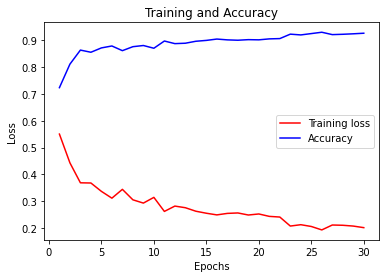

In [106]:
import matplotlib.pyplot as plt

loss = history.history['loss']
accuracy = history.history['accuracy']
epochs = range(1, len(loss) + 1)            # for x, use len(loss)

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, accuracy, 'b', label='Accuracy')
plt.title('Training and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [107]:
yhat = model.predict(x_val)
print('yhat shape:', yhat.shape)
print('one sample:', yhat[0])
print(val_trait_list[0])

yhat shape: (8000, 2)
one sample: [0.6599113  0.34008873]
0


In [108]:
predicted = []
for i, iyhat in enumerate(yhat):
    if i < 20:
        predicted.append(np.argmax(iyhat))
        print('image={}, predicted={}, label={}'.format(i, predicted[i], val_trait_list[i]))

image=0, predicted=0, label=0
image=1, predicted=0, label=0
image=2, predicted=0, label=0
image=3, predicted=1, label=1
image=4, predicted=1, label=1
image=5, predicted=1, label=1
image=6, predicted=1, label=1
image=7, predicted=0, label=0
image=8, predicted=0, label=0
image=9, predicted=1, label=1
image=10, predicted=0, label=1
image=11, predicted=1, label=1
image=12, predicted=0, label=0
image=13, predicted=0, label=0
image=14, predicted=1, label=1
image=15, predicted=0, label=0
image=16, predicted=0, label=0
image=17, predicted=0, label=0
image=18, predicted=0, label=0
image=19, predicted=1, label=1


In [111]:
def img_predict_show(x_val,val_trait_list,yhat,idx):
    plt.imshow(x_val[idx].squeeze())
    plt.title("Image {}\nPredicted = {}\nLabel = {}".format(idx,np.argmax(yhat[idx]),val_trait_list[idx]))

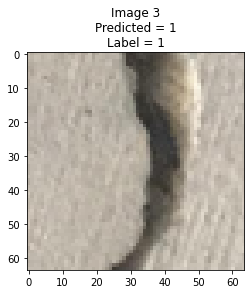

In [121]:
img_predict_show(x_val,val_trait_list,yhat,3) #마지막 파라메터에 원하는 인덱스를 입력하면 해당 이미지와 예측값, 실제 라벨을 볼 수 있다.